In [1]:
import matplotlib.pyplot as plt
import requests
import dill
import seaborn as sns
import tqdm.notebook as tq
import pandas as pd
import numpy as np
import logging
import pickle
import sys
import os

In [58]:
df = pd.read_csv('../data/DOR.csv')
df.shape

(2556, 11)

In [59]:
df.self_text = df.self_text.astype(str)
df['text'] = df.title + ' ' + df.self_text

In [60]:
for i in range(100):
    print(df.text[i])

What is Dotmund's specialty? I'm a BVB supporter and will keep on being a BVB supporter forever. But what makes BVB special? What is that one single ingredient that makes us hope for something big like our own Leagure title or Champions League? I'm a 17 year old and I don't understand football tactics or strategies or formation that much. But I want to learn about it. I want to become a die-hard Dortmund fan. Because I fell in love with its logo and jersey the moment I saw it for the first time a year ago.
Matchday Posters Mit schwarzgelben Grüßen.

Finally got around to putting a frame on this poster I got in Dortmund last year. It was posted outside a shop on Lindemannstraße. I went inside, told the shop owner I was visiting, and asked her if I could give her money for it. After 10 minutes or so of me offering more and more for it and her declining she eventually, and kindly, offered it for free. I was very grateful and said I would buy €20 of goods from her shop in exchange (I hope 

In [3]:
df.tail()

,author,created_utc,id,num_comments,score,self_text,subreddit,title,upvote_ratio,url,date
35976,TomJHIggins,1.627749e+09,ova7w0,196.0,1.0,NaN,Gunners,Inter Milan have set a price of €70m for Lauta...,1.0,https://twitter.com/osmanzthegooner/status/142...,2021-08-01 00:29:05
35977,existential_tony,1.627748e+09,ov9xun,10.0,1.0,NaN,Gunners,This lineup with good squad depth (second GK a...,1.0,https://i.redd.it/vesfpon0pke71.jpg,2021-08-01 00:13:27
35978,dhiaizk,1.627748e+09,ov9xly,121.0,1.0,NaN,Gunners,"[The Athletic] Chelsea, Liverpool and PSG were...",1.0,https://twitter.com/theathleticuk/status/14215...,2021-08-01 00:13:05
35979,TomJHIggins,1.627748e+09,ov9x7g,170.0,1.0,NaN,Gunners,Arsenal and Inter are still in negotiations fo...,1.0,https://www.calciomercato.it/2021/07/31/calcio...,2021-08-01 00:12:24
35980,Mkbw50,1.627748e+09,ov9t2s,16.0,1.0,NaN,Gunners,"FT Ebbsfleet 1-4 Arsenal (Bingham; Swanson, Ed...",1.0,https://twitter.com/EUFCofficial/status/142149...,2021-08-01 00:05:52


In [4]:
df.self_text.isnull().sum()

28738

In [7]:
# Bin Settings
def binSize(lower, upper, buffer=.05):
    bins = upper - lower
    buffer = int(buffer*bins)
    bins -= buffer
    print('Lower Bound:', lower)
    print('Upper Bound:', upper)
    return bins, lower, upper

# Plotting 
def plotHist(tmp, bins, title, xlabel, ylabel, l, u):
    plt.figure(figsize=(10,6))
    plt.hist(tmp, bins="auto")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(lower + l, upper + u)
    print('\nLocal Max %s:' % xlabel, max(tmp))
    print('Local Average %s:' % xlabel, int(np.mean(tmp)))
    print('Local Median %s:' % xlabel, int(np.median(tmp)))

Lower Bound: 0
Upper Bound: 175

Local Max Scoring: 175.0
Local Average Scoring: 2
Local Median Scoring: 1


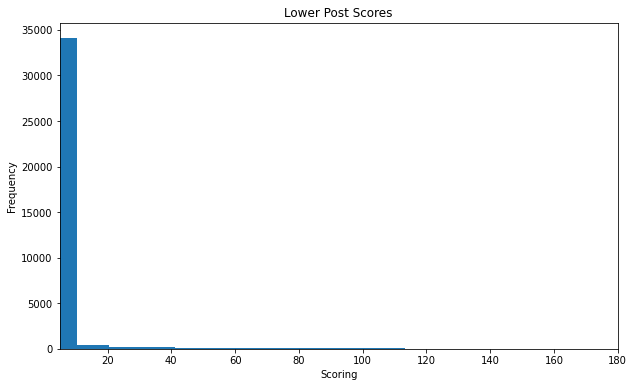

In [8]:
# Create the correct bin size
bins, lower, upper = binSize(lower=0, upper=175)

# Plot distribution of lower scores
tmp = df[[ True if lower <= x <= upper else False for x in df['score'] ]]['score']
plotHist(tmp=tmp, bins=bins, title='Lower Post Scores', xlabel='Scoring', ylabel='Frequency', l=5, u=5);

Lower Bound: 0
Upper Bound: 300

Local Max Length: 309
Local Average Length: 80
Local Median Length: 57


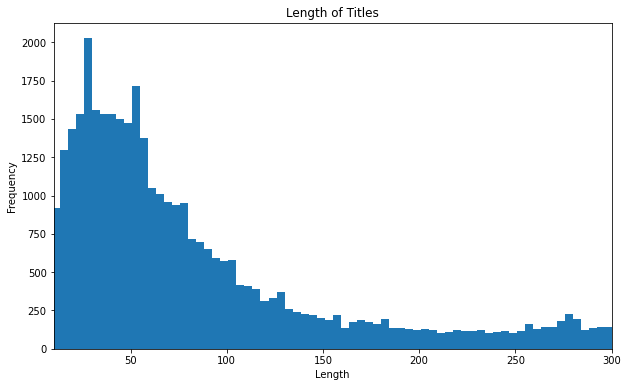

In [9]:
tmp = [len(t) for t in df.title]
# Create the correct bin size
bins, lower, upper = binSize(lower=0, upper=300)

# Plot distribution of lower scores
plotHist(tmp=tmp, bins=bins, title='Length of Titles', xlabel='Length', ylabel='Frequency', l=10, u=0);

In [3]:
df.self_text = df.self_text.astype(str)

Lower Bound: 500
Upper Bound: 5000

Local Max Length: 4994
Local Average Length: 1288
Local Median Length: 1012


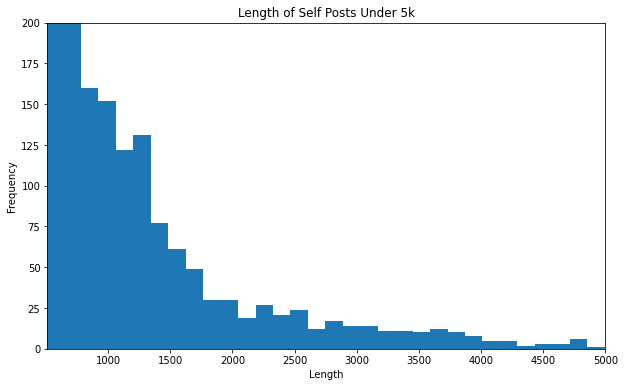

In [14]:
bins, lower, upper = binSize(lower=500, upper=5000, buffer=.011)
tmp = [len(x) for x in df.self_text if lower <= len(x) <= upper]

plotHist(tmp=tmp, bins=bins, title='Length of Self Posts Under 5k', xlabel='Length', ylabel='Frequency', l=10, u=0)
plt.ylim(0, 200);

In [4]:
df['text'] = df.title + ' ' + df.self_text

In [5]:
def clean_text(df, text_field):
    '''
    Clean all the text data within a certain text column of the dataFrame.
    '''
    df[text_field] = df[text_field].str.replace(r"http\S+", " ")
    df[text_field] = df[text_field].str.replace(r"&[a-z]{2,4};", "")
    df[text_field] = df[text_field].str.replace("\\n", " ")
    df[text_field] = df[text_field].str.replace(r"#f", "")
    df[text_field] = df[text_field].str.replace(r"[\’\'\`\":]", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9]", " ")
    df[text_field] = df[text_field].str.replace(r" +", " ")
    df[text_field] = df[text_field].str.lower()
    

In [6]:
clean_text(df, 'text')

In [8]:
import nltk

In [9]:
from nltk.corpus import stopwords

stop = stopwords.words('english')
stop.extend([x.replace("\'", "") for x in stop])
stop.extend(['nbsp', 'also', 'really', 'ive', 'even', 'jon', 'lot', 'could', 'many'])
stop = list(set(stop))

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cv = CountVectorizer(token_pattern='\\w{3,}', max_df=.30, min_df=.0001,
                     stop_words=stop, ngram_range=(1,1),lowercase=False,dtype='uint8')

tfidf = TfidfVectorizer(token_pattern='\\w{3,}', max_df=.30, min_df=.0001, 
                        stop_words=stop, ngram_range=(1,1), lowercase=False,
                        sublinear_tf=True, smooth_idf=False, dtype='float32')

In [7]:
df.sample(3)['text']

27534    how ruben neves would fit at arsenal statman d...
28558     chris wheatley cedric soares to fenerbahce ru...
23915    the boys showing love for david luiz post trai...
Name: text, dtype: object

In [31]:
df.text

0        xhaka is such shit when will arsenal fans fina...
1         discussion realistically if pepe has another ...
2        realistically if pepe has another similar seas...
3        how would you rate our transfer activity weve ...
4        psa there are 2 weeks left until the release o...
                               ...                        
35976    inter milan have set a price of 70m for lautar...
35977    this lineup with good squad depth second gk an...
35978     the athletic chelsea liverpool and psg were a...
35979    arsenal and inter are still in negotiations fo...
35980    ft ebbsfleet 1 4 arsenal bingham swanson edwar...
Name: text, Length: 35981, dtype: object

In [32]:
%%time
cv_vecs = cv.fit_transform(df.text).transpose()
tf_vecs = tfidf.fit_transform(df.text).transpose()

CPU times: user 1.55 s, sys: 26.5 ms, total: 1.58 s
Wall time: 1.6 s


In [12]:
print("Sparse Shape:", cv_vecs.shape) 
print('CV:', sys.getsizeof(cv_vecs))
print('Tf-Idf:', sys.getsizeof(tf_vecs))

Sparse Shape: (9695, 35981)
CV: 64
Tf-Idf: 64


In [13]:
tfidf_df = pd.DataFrame(tf_vecs.transpose().todense(), columns=[tfidf.get_feature_names()]).astype('float32')
cv_df = pd.DataFrame(cv_vecs.transpose().todense(), columns=[cv.get_feature_names()]).astype('uint8')

In [14]:
print(cv_df.info())
print(tfidf_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35981 entries, 0 to 35980
Columns: 9695 entries, ('000',) to ('zrafc',)
dtypes: uint8(9695)
memory usage: 332.7 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35981 entries, 0 to 35980
Columns: 9695 entries, ('000',) to ('zrafc',)
dtypes: float32(9695)
memory usage: 1.3 GB
None


In [15]:
cv_description = cv_df.describe().T
tfidf_description = tfidf_df.describe().T

tfidf_df.sum().sort_values(ascending=False)

arsenal        1323.978027
arteta          495.359711
league          435.411713
season          410.711273
removed         379.440826
                  ...     
grain             0.222408
vary              0.199231
variance          0.198642
normalize         0.177967
conjunction       0.167288
Length: 9695, dtype: float32

In [16]:
cv_description.sort_values(by='max', ascending=False)

,count,mean,std,min,25%,50%,75%,max
000,35981.0,0.006087,0.587948,0.0,0.0,0.0,0.0,110.0
arsenal,35981.0,0.393069,1.040987,0.0,0.0,0.0,1.0,109.0
x200b,35981.0,0.017509,0.503599,0.0,0.0,0.0,0.0,70.0
average,35981.0,0.006170,0.347333,0.0,0.0,0.0,0.0,58.0
far,35981.0,0.013118,0.277155,0.0,0.0,0.0,0.0,47.0
...,...,...,...,...,...,...,...,...
jake,35981.0,0.000334,0.018259,0.0,0.0,0.0,0.0,1.0
jairo,35981.0,0.000111,0.010543,0.0,0.0,0.0,0.0,1.0
jahfieldarbuckle,35981.0,0.000139,0.011788,0.0,0.0,0.0,0.0,1.0
jahanbakhsh,35981.0,0.000139,0.011788,0.0,0.0,0.0,0.0,1.0


In [17]:
tfidf_description.sort_values(by='mean',ascending = False)

,count,mean,std,min,25%,50%,75%,max
arsenal,35981.0,0.036797,0.067576,0.0,0.0,0.0,0.070508,1.000000
arteta,35981.0,0.013767,0.057519,0.0,0.0,0.0,0.000000,1.000000
league,35981.0,0.012101,0.049608,0.0,0.0,0.0,0.000000,0.614790
season,35981.0,0.011415,0.050724,0.0,0.0,0.0,0.000000,1.000000
removed,35981.0,0.010546,0.067473,0.0,0.0,0.0,0.000000,1.000000
...,...,...,...,...,...,...,...,...
grain,35981.0,0.000006,0.000651,0.0,0.0,0.0,0.000000,0.099118
vary,35981.0,0.000006,0.000553,0.0,0.0,0.0,0.000000,0.070803
variance,35981.0,0.000006,0.000589,0.0,0.0,0.0,0.000000,0.093717
normalize,35981.0,0.000005,0.000501,0.0,0.0,0.0,0.000000,0.073042


# SVD

In [18]:
from sklearn.utils.extmath import randomized_svd

In [19]:
U, Sigma, VT = randomized_svd(tf_vecs, n_components=8, random_state=42)

In [20]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

def Trunc_SVD(vectorized, n_components=300, iterations=1, normalize=False, random_state=42):
    """
    Performs LSA/LSI on a sparse document term matrix, returns a fitted, transformed, (normalized) LSA object
    """
    # Already own the vectorized data for LSA, just transpose it back to normal
    vecs_lsa = vectorized.T

    # Initialize SVD object as LSA
    lsa = TruncatedSVD(n_components=n_components, n_iter=iterations, algorithm='randomized', random_state=random_state)
    dtm_lsa = lsa.fit(vecs_lsa)
    print("Explained Variance - LSA {}:".format(n_components), dtm_lsa.explained_variance_ratio_.sum())
    if normalize:
        dtm_lsa_t = lsa.fit_transform(vecs_lsa)
        dtm_lsa_t = Normalizer(copy=False).fit_transform(dtm_lsa_t)
        return dtm_lsa, dtm_lsa_t
    return dtm_lsa


def plot_SVD(lsa, title, level=None):
    """
    Plots the singular values of an LSA object
    """
    plt.figure(num=1, figsize=(15,10))
    plt.suptitle(title, fontsize=22, x=.55, y=.45, horizontalalignment='left')
    plt.subplot(221)
    plt.title('Explained Variance by each Singular Value')
    plt.plot(lsa.explained_variance_[:level])
    
    plt.subplot(222)
    plt.title('Explained Variance Ratio by each Singular Value')
    plt.plot(lsa.explained_variance_ratio_[:level])
    
    plt.subplot(223)
    plt.title("Singular Values ('Components')")
    plt.plot(lsa.singular_values_[:level])
    plt.show()

Explained Variance - LSA 300: 0.6800826747132538


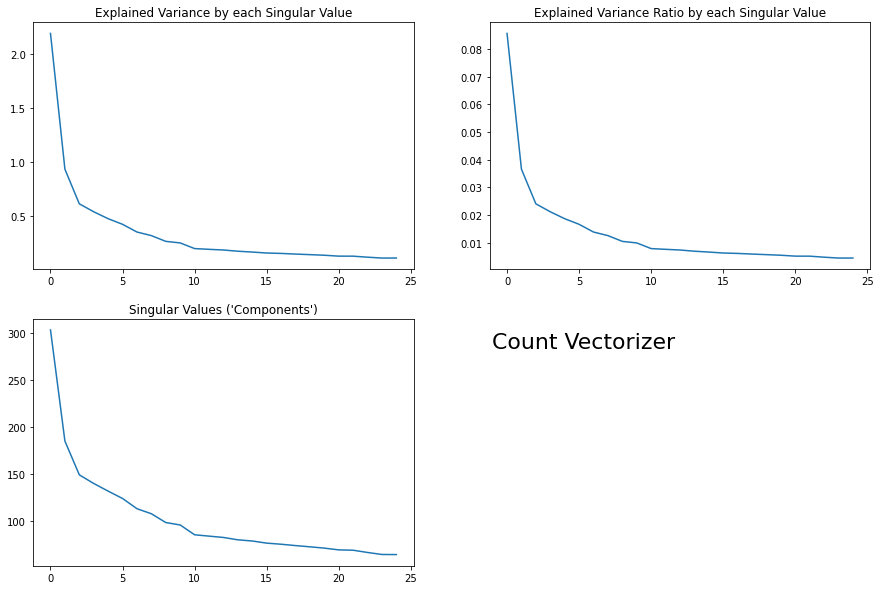

Explained Variance - LSA 300: 0.35168546


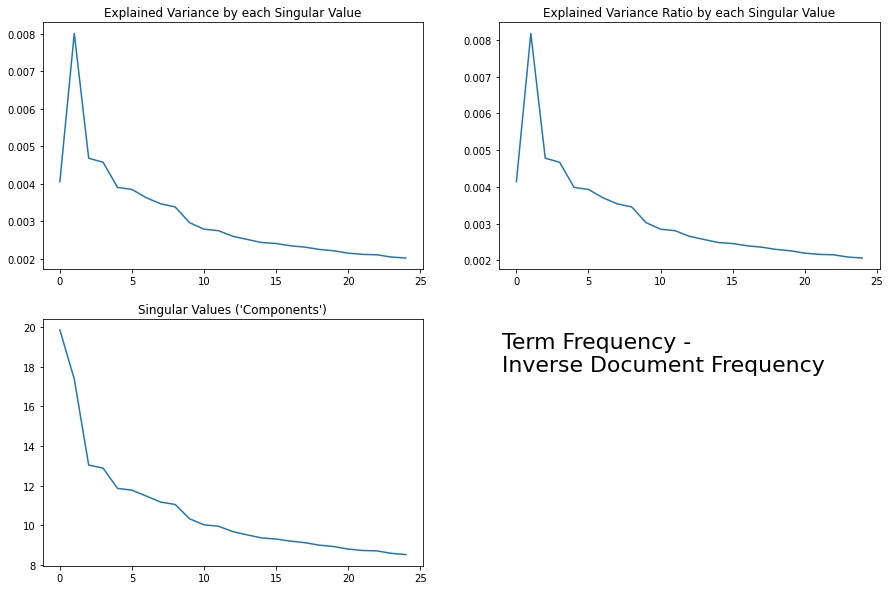

In [21]:
cv_dtm_lsa = Trunc_SVD(cv_vecs,iterations=5)
plot_SVD(cv_dtm_lsa, title='Count Vectorizer', level=25)

tf_dtm_lsa = Trunc_SVD(tf_vecs, iterations=5)
plot_SVD(tf_dtm_lsa, title='Term Frequency - \nInverse Document Frequency', level=25)

In [25]:
print('SVD Value| CV | TFIDF')
print('Top 2:  ',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:2])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:2])),3))
print('Top 3:  ',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:3])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:3])),3))
print('Top 4:  ',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:4])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:4])),3))
print('Top 5:  ',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:5])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:5])),3))
print('Top 6:  ',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:6])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:6])),3))
print('Top 7:  ',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:7])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:7])),3))
print('Top 8:  ',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:8])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:8])),3))
print('Top 16:\t',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:16])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:16])),3))
print('Top 32:\t',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:32])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:32])),3))
print('Top 64:\t',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:64])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:64])),3))
print('Top 128:',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:128])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:128])),3))
print('Top 256:',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:256])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:256])),3))
print('Top 300:',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:300])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:300])),3))

SVD Value| CV | TFIDF
Top 2:   0.122 0.012
Top 3:   0.146 0.017
Top 4:   0.168 0.022
Top 5:   0.186 0.026
Top 6:   0.203 0.03
Top 7:   0.217 0.033
Top 8:   0.229 0.037
Top 16:	 0.293 0.059
Top 32:	 0.368 0.093
Top 64:	 0.454 0.145
Top 128: 0.551 0.222
Top 256: 0.657 0.326
Top 300: 0.68 0.352


Explained Variance Ratio (EVR):
 [0.08565611 0.03660205 0.02408503 0.02121759 0.01871353 0.01668225
 0.01389383 0.01260116 0.01051775 0.00995665 0.00791451 0.00764345
 0.00740151 0.00696141 0.00666044 0.00631395 0.00616722 0.00593288
 0.00572521 0.00550771]
Difference in EVR (start 3):
 [-0.00286744 -0.00250406 -0.00203128 -0.00278842 -0.00129267 -0.00208341
 -0.0005611  -0.00204215 -0.00027105 -0.00024194 -0.00044011 -0.00030097
 -0.00034648 -0.00014673 -0.00023434 -0.00020767 -0.0002175 ]


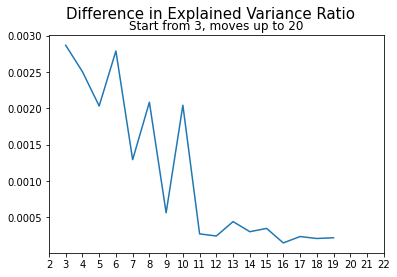

In [29]:
def elbow(dtm_lsa):
    evr = dtm_lsa.explained_variance_ratio_[:20]
    print("Explained Variance Ratio (EVR):\n", evr)
    print("Difference in EVR (start 3):\n", np.diff(evr[2:]))
    plt.figure()
    plt.plot(-np.diff(evr[2:]))
    plt.xticks(range(-1,20), range(2,23))
    plt.suptitle('Difference in Explained Variance Ratio', fontsize=15);
    plt.title('Start from 3, moves up to 20');

# Count Vectorizer
elbow(cv_dtm_lsa)

In [40]:
df1 = pd.read_csv('../data/all_posts.csv')
df1.shape

(176559, 11)